In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/blood-cells")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'blood-cells' dataset.
Path to dataset files: /kaggle/input/blood-cells


In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_dir='/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
class_labels=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']

In [ ]:
filepaths=[]
labels=[]
for label in class_labels:
    class_dir=os.path.join(data_dir,label)
    for file in os.listdir(class_dir):
      if file.endswith('.jpeg') or file.endswith('.png'):
        filepaths.append(os.path.join(class_dir,file))
        labels.append(label)

In [ ]:
bloodcell_df=pd.DataFrame({'filepath':filepaths,'label':labels})
bloodcell_df=bloodcell_df.sample(frac=1).reset_index(drop=True)
bloodcell_df.head()

,filepath,label
0,/kaggle/input/blood-cells/dataset2-master/data...,EOSINOPHIL
1,/kaggle/input/blood-cells/dataset2-master/data...,EOSINOPHIL
2,/kaggle/input/blood-cells/dataset2-master/data...,MONOCYTE
3,/kaggle/input/blood-cells/dataset2-master/data...,NEUTROPHIL
4,/kaggle/input/blood-cells/dataset2-master/data...,NEUTROPHIL


In [ ]:
train_images,test_images=train_test_split(bloodcell_df,test_size=0.3,random_state=42)
train_set,val_set=train_test_split(bloodcell_df,test_size=0.2,random_state=42)

In [ ]:
print(train_images.shape)
print(val_set.shape)
print(test_images.shape)
print(train_set.shape)

(6969, 2)
(1992, 2)
(2988, 2)
(7965, 2)


In [ ]:
image_gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
train=image_gen.flow_from_dataframe(dataframe=train_set,x_col='filepath',y_col='label',target_size=(244,244),color_mode='rgb',class_mode='categorical',
                                    batch_size=8,
                                    shuffle=False)
test=image_gen.flow_from_dataframe(dataframe=test_images,x_col='filepath',y_col='label',target_size=(244,244),color_mode='rgb',class_mode='categorical',
                                    batch_size=8,
                                    shuffle=False)
val=image_gen.flow_from_dataframe(dataframe=val_set,x_col='filepath',y_col='label',target_size=(244,244),color_mode='rgb',class_mode='categorical',
                                    batch_size=8,
                                    shuffle=False)

Found 7965 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1992 validated image filenames belonging to 4 classes.


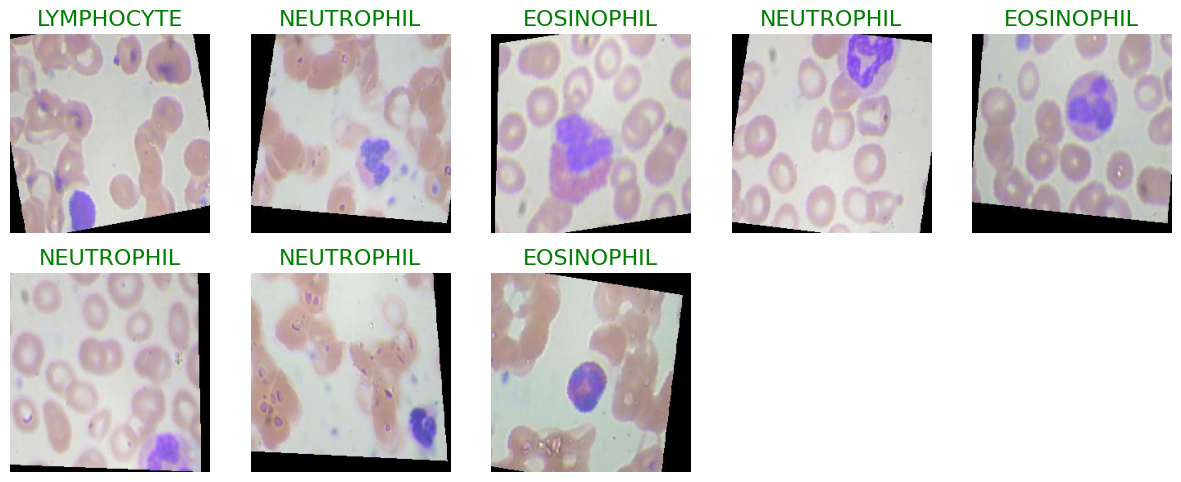

In [ ]:
import numpy as np
def show_knee_images(image_gen):
  test_dict=test.class_indices
  classes=list(test_dict.keys())
  images,labels=next(image_gen)
  plt.figure(figsize=(15,15))
  length=len(images)
  if(length<25):
    r=length
  else:
    r=25
  for i in range(r):
    plt.subplot(5,5,i+1)
    image=(images[i]+1)/2
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name=classes[index]
    plt.title(class_name,color="green",fontsize=16)
    plt.axis('off')
  plt.show()
show_knee_images(train)


In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128,kernel_size=(8,8),activation='relu',input_shape=(244,244,3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256,kernel_size=(5,5),activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(3,3)),

    keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Conv2D(filters=512,kernel_size=(3,3),activation='relu',padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4,activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 237, 237, 128)  │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 237, 237, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 237, 237, 256)  │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 237, 237, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 79, 79, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 79, 79, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 79, 79, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 79, 79, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 79, 79, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 79, 79, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 79, 79, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 79, 79, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 39, 39, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 39, 39, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 39, 39, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 39, 39, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 39, 39, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 39, 39, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 39, 39, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 52,112,516 (198.79 MB)

 Trainable params: 52,106,116 (198.77 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [ ]:
history=model.fit(train,epochs=5,validation_data=val,verbose=1)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 756s 711ms/step - accuracy: 0.2758 - loss: 7.9989 - val_accuracy: 0.3881 - val_loss: 1.2581
Epoch 2/5
996/996 ━━━━━━━━━━━━━━━━━━━━ 666s 669ms/step - accuracy: 0.3651 - loss: 1.3743 - val_accuracy: 0.4121 - val_loss: 1.4057
Epoch 3/5
996/996 ━━━━━━━━━━━━━━━━━━━━ 666s 669ms/step - accuracy: 0.4034 - loss: 1.2830 - val_accuracy: 0.3830 - val_loss: 1.6827
Epoch 4/5
996/996 ━━━━━━━━━━━━━━━━━━━━ 665s 668ms/step - accuracy: 0.4965 - loss: 1.1568 - val_accuracy: 0.3715 - val_loss: 1.9828
Epoch 5/5
996/996 ━━━━━━━━━━━━━━━━━━━━ 664s 667ms/step - accuracy: 0.5612 - loss: 0.9681 - val_accuracy: 0.6340 - val_loss: 0.8402


In [ ]:
history1=model.fit(train,epochs=1,validation_data=val,verbose=1)

996/996 ━━━━━━━━━━━━━━━━━━━━ 665s 668ms/step - accuracy: 0.6319 - loss: 0.8060 - val_accuracy: 0.6616 - val_loss: 0.6865


In [ ]:
pred=model.predict(test)
pred=np.argmax(pred,axis=1)

labels=(train.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred2=[labels[k] for k in pred]

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 115s 306ms/step


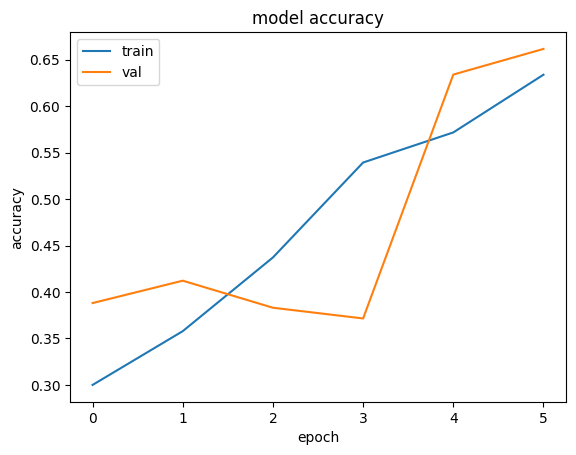

In [ ]:
plt.plot(history.history['accuracy']+ history1.history['accuracy'])
plt.plot(history.history['val_accuracy']+ history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()


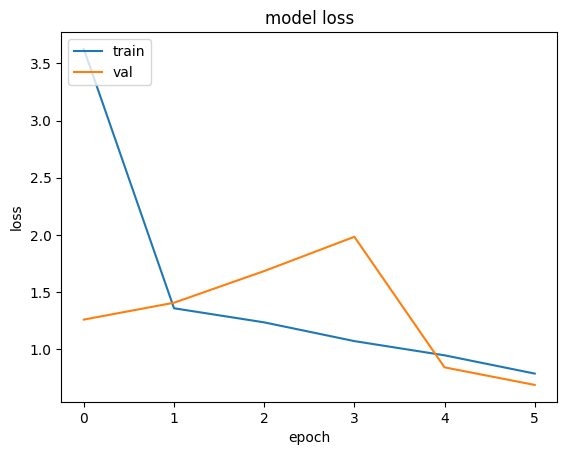

In [ ]:
plt.plot(history.history['loss']+ history1.history['loss'])
plt.plot(history.history['val_loss']+ history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [ ]:
y_test=test_images.label
print(classification_report(y_test,pred2))

              precision    recall  f1-score   support

  EOSINOPHIL       0.50      0.65      0.56       753
  LYMPHOCYTE       0.74      0.97      0.84       756
    MONOCYTE       0.97      0.86      0.91       731
  NEUTROPHIL       0.42      0.20      0.27       748

    accuracy                           0.67      2988
   macro avg       0.66      0.67      0.65      2988
weighted avg       0.65      0.67      0.65      2988



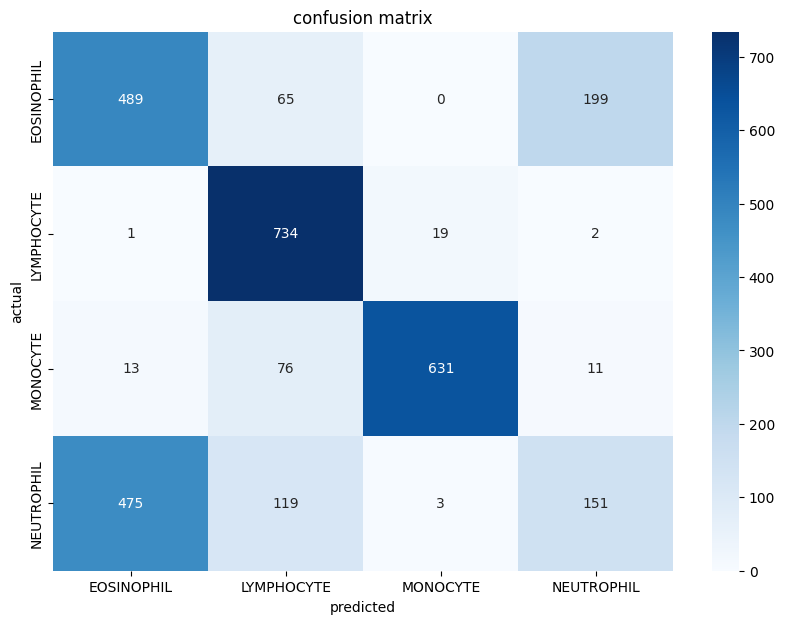

In [ ]:
cm=confusion_matrix(y_test,pred2)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='Blues')
plt.xticks(ticks=[0.5,1.5,2.5,3.5],labels=class_labels)
plt.yticks(ticks=[0.5,1.5,2.5,3.5],labels=class_labels)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix")
plt.show()

In [ ]:
model.save("Blood Cell.keras")